# Numerical simulation of FAST applied to a generic image from scikit-image


In [1]:
import ipyparallel as ipp

In [2]:
cluster = ipp.Cluster(engines="mpi", n=12)

In [3]:
rc = cluster.start_and_connect_sync()

Starting 12 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/12 [00:00<?, ?engine/s]

In [4]:
dv = rc[:]

In [5]:
%%px --local
%load_ext autoreload
%autoreload 2

In [6]:
%%px

from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

In [7]:
%%px --local
from pathlib import Path

import cv2
import fast.s26_analysis.utils as utils
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import odl
import skimage
import tifffile as tif
from cycler import cycler
from fast.utils.generate_scan_pattern import generate_scan_pattern as gcn
from fast.utils.img_loader import load_image_list_renormalize, renormalize
from markers_and_labels import KWARGS_PER_LABEL, LABELS
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
from tqdm.notebook import tqdm

In [8]:
%%px
frbh = lambda x, m: skimage.restoration.inpaint_biharmonic(x * m, (1 - m).astype("bool"))
frns = lambda x, m: cv2.inpaint(x * m, 1 - m, 10, cv2.INPAINT_NS)

In [9]:
shape = np.array([128, 128])

In [10]:
shape_this = shape
space_this = odl.uniform_discr([-1, -1], [1, 1], shape=shape)
sp_orig = renormalize(odl.phantom.shepp_logan(space_this, modified=True).asarray().T[::-1])

sp_nonzero = sp_orig[sp_orig > 0]
print(np.unique(sp_nonzero))

slp = np.pad(sp_orig, [64 - shape_this // 2, 64 - shape_this // 2])
noise_this = odl.phantom.noise.white_noise(space_this, stddev=0.5).asarray()
slp += noise_this

[  10.   20.   30.   40.  100.]


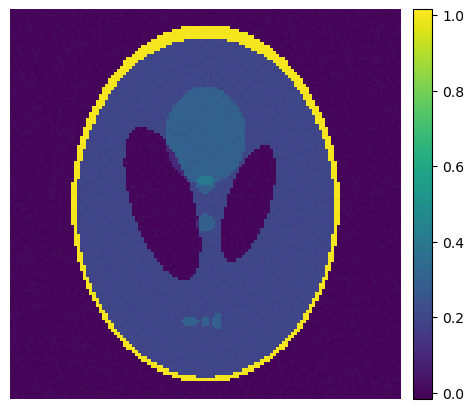

In [73]:
plt.figure(figsize=[5, 4], constrained_layout=True)
plt.imshow(slp / 100, rasterized=False)
# plt.title("Ground truth")
plt.gca().axis("off")
plt.colorbar(pad=0.03)
# plt.savefig(f"{figures_dir}/shepp_logan.svg", bbox_inches="tight", transparent=True, dpi=300)
plt.savefig(f"{figures_dir}/shepp_logan.pdf", bbox_inches="tight", transparent=True, dpi=300)
plt.show()

In [74]:
f"{figures_dir}/shepp_logan.svg"

'paper_figures_and_results/slp/shepp_logan.svg'

In [75]:
figures_dir

PosixPath('paper_figures_and_results/slp')

In [78]:
! du -hc paper_figures_and_results/slp/*

40K	paper_figures_and_results/slp/shepp_logan.pdf
32K	paper_figures_and_results/slp/ssims.pdf
72K	total


In [13]:
dv["slp"] = slp

### Simulating the FAST procedure only

In [14]:
# Get a 1% measurement mask
init_pattern = gcn(*slp.T.shape, 0.01)

Initial ratio is 0.00994873046875


/home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/scipy/stats/_qmc.py:763: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Text(0.5, 1.0, 'Initial scan pattern')

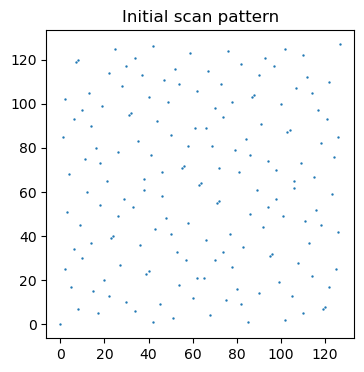

In [15]:
plt.figure(figsize=[4, 4])
plt.scatter(init_pattern[:, 1], init_pattern[:, 0], s=0.5)
# plt.vlines([0, 128], ymin=0, ymax=128, color='magenta')
# plt.hlines([0, 128], xmin=0, xmax=128, color='magenta')
plt.gca().set_aspect("equal")
plt.title("Initial scan pattern")

In [16]:
dv["init_pattern"] = init_pattern

In [17]:
models_list = list(Path.cwd().glob("trained_models/*/c_2/*_relu.pkl"))

In [18]:
names = [m.parent.parent.name for m in models_list]
models_to_compare = {n: m for n, m in zip(names, models_list)}
models_to_compare[
    "cameraman"
] = "/home/beams/SKANDEL/code/fast_smart_scanning/work_directory/training/cameraman/c_2/erd_model_relu.pkl"

In [19]:
list(models_to_compare.items())

[('4.1.05',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.05/c_2/erd_model_relu.pkl')),
 ('4.1.01',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.01/c_2/erd_model_relu.pkl')),
 ('camera_new',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/camera_new/c_2/erd_model_relu.pkl')),
 ('4.2.03',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.03/c_2/erd_model_relu.pkl')),
 ('5.1.11',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.1.11/c_2/erd_model_relu.pkl')),
 ('4.1.08',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.08/c_2/erd_model_relu.pkl')),
 ('5.3.01',
  PosixPath('/home/beams0/SKANDEL/code/fast_smart_scanning/wor

In [20]:
dv.scatter("models", models_to_compare)

<AsyncResult(scatter): pending>

In [21]:
dv["models_to_compare"] = models_to_compare

In [21]:
%%px
masks_all = []
recons_fast_all = []
ratios_all = []
tot_erds_all = []
samples_all = []
for mtype in models:
    model = models_to_compare[mtype]
    print(model)
    sample_this = utils.create_experiment_sample(
        numx=slp.shape[1],
        numy=slp.shape[0],
        inner_batch_size=50,
        initial_idxs=init_pattern,
        erd_model_file_path=model,
    )
    masks_this = []
    recons_fast_this = []
    ratios_this = []
    tot_erds_this = []

    count = 0
    new_idxs = init_pattern

    n_scan_points = int(0.5 * slp.size)
    pbar = tqdm(total=n_scan_points, desc="Scanned points")
    # Continue until we measure 40% of the points.
    while sample_this.mask.sum() < n_scan_points:
        # Supply the measurement values.
        sample_this.measurement_interface.finalize_external_measurement(slp[new_idxs[:, 0], new_idxs[:, 1]])

        # Supply in measurement positions
        sample_this.perform_measurements(new_idxs)

        # Use the measurement values to reconstruct the sample and calculate the ERDs
        sample_this.reconstruct_and_compute_erd()

        # Compute new positions.
        new_idxs = sample_this.find_new_measurement_idxs()[:50]

        ratio = sample_this.ratio_measured
        ratios_this.append(ratio)
        tot_erds_this.append(sample_this.ERD.sum())
        recons_fast_this.append(sample_this.recon_image.copy())
        masks_this.append(sample_this.mask.copy())
        pbar.update(int(sample_this.mask.sum() - pbar.n))

    masks_all.append(masks_this)
    recons_fast_all.append(recons_fast_this)
    ratios_all.append(ratios_this)
    tot_erds_all.append(tot_erds_this)
    samples_all.append(sample_this)

[stdout:0] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.05/c_2/erd_model_relu.pkl


[stdout:10] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/all_combined/c_2/erd_model_relu.pkl


[stderr:0] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stdout:4] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.1.11/c_2/erd_model_relu.pkl


[output:0]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stdout:3] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.03/c_2/erd_model_relu.pkl


[stdout:1] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.01/c_2/erd_model_relu.pkl


[stdout:9] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.1.12/c_2/erd_model_relu.pkl


[stderr:10] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:10]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stderr:4] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stderr:3] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:4]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stderr:1] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[stderr:9] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:3]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[output:1]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stdout:5] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.1.08/c_2/erd_model_relu.pkl


[output:9]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stdout:6] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/5.3.01/c_2/erd_model_relu.pkl


[stderr:5] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:5]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stderr:6] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:6]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stdout:8] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.07/c_2/erd_model_relu.pkl


[stderr:8] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:8]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stdout:2] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/camera_new/c_2/erd_model_relu.pkl


[stderr:2] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:2]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stdout:11] /home/beams/SKANDEL/code/fast_smart_scanning/work_directory/training/cameraman/c_2/erd_model_relu.pkl


[stdout:7] /home/beams0/SKANDEL/code/fast_smart_scanning/work_directory/training_usc_sipi/trained_models/4.2.06/c_2/erd_model_relu.pkl


[output:11]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

[stderr:7] /home/beams/SKANDEL/miniforge3/envs/fast/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[output:7]

Scanned points:   0%|          | 0/8192 [00:00<?, ?it/s]

%px:   0%|          | 0/13 [00:00<?, ?tasks/s]

In [22]:
%%px
labels_this = []
for m in models:
    labels_this.append(LABELS[m])

In [22]:
%%px --local
inpainting = True
reload_saved_results = True

In [23]:
%%px
if reload_saved_results:
    assert False
skip = 5

results_per_label = {}

for n1, modname in enumerate(models):
    label = LABELS[modname]
    results_per_label[label] = {}

    if inpainting:
        results_per_label[label]["recons_bh"] = []
    results_per_label[label]["indices"] = []
    results_per_label[label]["ssims"] = []
    results_per_label[label]["psnrs"] = []
    results_per_label[label]["rmses"] = []
    results_per_label[label]["ratios"] = []
    results_per_label[label]["masks"] = []

    for n2, scan_ratio in tqdm(enumerate(ratios_all[n1])):
        if n2 % skip != 0:
            continue
        if scan_ratio > 0.5:
            continue

        _r1 = recons_fast_all[n1][n2]
        _m1 = masks_all[n1][n2].astype("bool")

        actual_max = slp[_m1][np.argmax(_r1[_m1])]
        actual_min = slp[_m1][np.argmin(_r1[_m1])]

        _r2 = renormalize(_r1, max_value=255, min_value=0).astype(
            "float32"
        )  # actual_max, min_value=actual_min).astype('float32')

        if inpainting:
            _r2 = frbh(_r2, _m1)
            # _r2 = recons_scipy(_r2, _m1, kernel='inverse_quadratic')
            # _r2 = frns(_r2, _m1.astype("uint8"))
            _r2[_r2 > 255] = 255
            _r2[_r2 < 0] = 0
        _r2 = renormalize(_r2, max_value=actual_max, min_value=actual_min)
        results_per_label[label]["ssims"].append(skimage.metrics.structural_similarity(slp, _r2, data_range=100))
        results_per_label[label]["psnrs"].append(skimage.metrics.peak_signal_noise_ratio(slp, _r2, data_range=100))
        results_per_label[label]["rmses"].append(skimage.metrics.normalized_root_mse(slp, _r2))
        results_per_label[label]["masks"].append(_m1)

        results_per_label[label]["ratios"].append(scan_ratio)
        if inpainting:
            results_per_label[label]["recons_bh"].append(
                _r2,
            )
    for k, v in results_per_label[label].items():
        results_per_label[label][k] = np.array(v)

[8:execute]
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In[6], line 2
      1 if reload_saved_results:
----> 2     assert False
      3 skip = 5
      5 results_per_label = {}

AssertionError: 
[0:execute]
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In[6], line 2
      1 if reload_saved_results:
----> 2     assert False
      3 skip = 5
      5 results_per_label = {}

AssertionError: 
[7:execute]
---------------------------------------------------------------------------
AssertionError                            Traceback (most recent call last)
Cell In[6], line 2
      1 if reload_saved_results:
----> 2     assert False
      3 skip = 5
      5 results_per_label = {}

AssertionError: 
[4:execute]
-------------------------------------------------------------------

AlreadyDisplayedError: 12 errors

In [24]:
save_dir = Path("fast_sim_data") / "slp"
if not reload_saved_results:
    dv.gather("results_per_label")

    results_all = {}
    for d in dv["results_per_label"]:
        results_all.update(d)

    save_dir.mkdir(exist_ok=True)
    if inpainting:
        save_fname = save_dir / "analysis_results_with_inpainting.joblib"
    else:
        save_fname = save_dir / "analysis_results_without_bh_inpainting.joblib"
    joblib.dump(results_all, save_fname, compress=5)
else:
    if inpainting:
        results_all = joblib.load(save_dir / "analysis_results_with_inpainting.joblib")
    else:
        results_all = joblib.load(save_dir / "analysis_results_without_bh_inpainting.joblib")

In [25]:
!du -hsc $save_dir

93M	fast_sim_data/slp
93M	total


In [29]:
results_all = {k: results_all[k] for k in sorted(results_all)}

In [30]:
figures_dir = Path("paper_figures_and_results/slp")
figures_dir.mkdir(exist_ok=True)

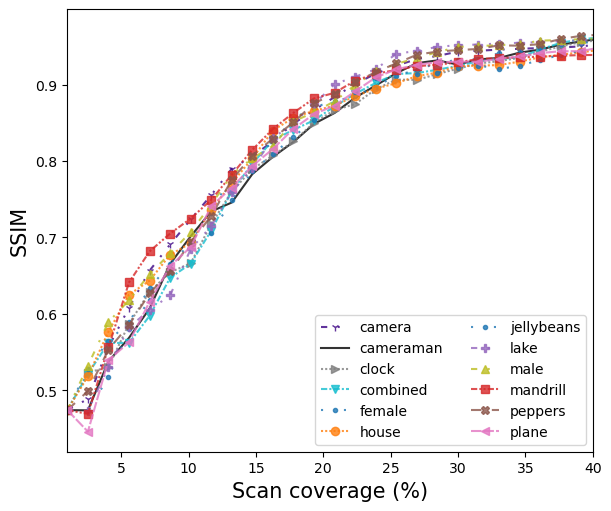

In [77]:
plt.figure(figsize=[6, 5], constrained_layout=True)
for ix, label in enumerate(results_all):
    KWARGS_PER_LABEL[label]["alpha"] = 0.8
    plt.plot(
        results_all[label]["ratios"] * 100,
        results_all[label]["ssims"],
        # markevery=0.15,
        label=label,
        **KWARGS_PER_LABEL[label],
    )
plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("SSIM", fontsize=15)
plt.legend(loc="best", ncols=2)

# plt.text(28, 0.8, r'$27\%$', size=18)
# plt.axvline(27, ls=':')
plt.xlim([1, 40])
# plt.savefig(f"{figures_dir}/ssims.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.savefig(f"{figures_dir}/ssims.pdf", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

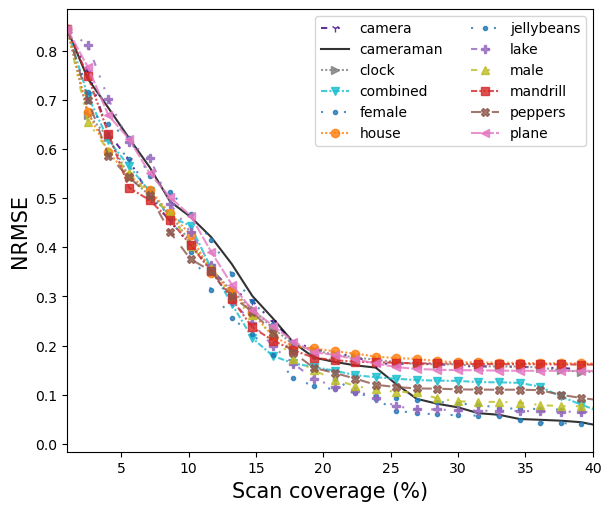

In [79]:
plt.figure(figsize=[6, 5], constrained_layout=True)
ax = plt.gca()


for ix, label in enumerate(results_all):
    KWARGS_PER_LABEL[label]["alpha"] = 0.8
    plt.plot(
        results_all[label]["ratios"] * 100,
        results_all[label]["rmses"],
        # markevery=0.1,
        label=label,
        **KWARGS_PER_LABEL[label],
    )

plt.xlabel("Scan coverage (%)", fontsize=15)
plt.ylabel("NRMSE", fontsize=15)
plt.legend(loc="best", ncols=2)
plt.xlim([1, 40])

# plt.savefig(f"{figures_dir}/nrmses.svg", bbox_inches="tight", dpi=600, transparent=True)
plt.savefig(f"{figures_dir}/nrmses.pdf", bbox_inches="tight", dpi=600, transparent=True)
plt.show()

In [83]:
ratios_to_plot = [0.1, 0.15, 0.2]

In [84]:
idxs_to_plot = {}
for k, v in results_all.items():
    idxs_to_plot[k] = [np.argmin(np.abs(v["ratios"] - r)) for r in ratios_to_plot]

In [85]:
idxs_to_plot

{'camera': [6, 9, 12],
 'cameraman': [6, 9, 12],
 'clock': [6, 9, 12],
 'combined': [6, 9, 12],
 'female': [6, 9, 12],
 'house': [6, 9, 12],
 'jellybeans': [6, 9, 12],
 'lake': [6, 9, 12],
 'male': [6, 9, 12],
 'mandrill': [6, 9, 12],
 'peppers': [6, 9, 12],
 'plane': [6, 9, 12]}

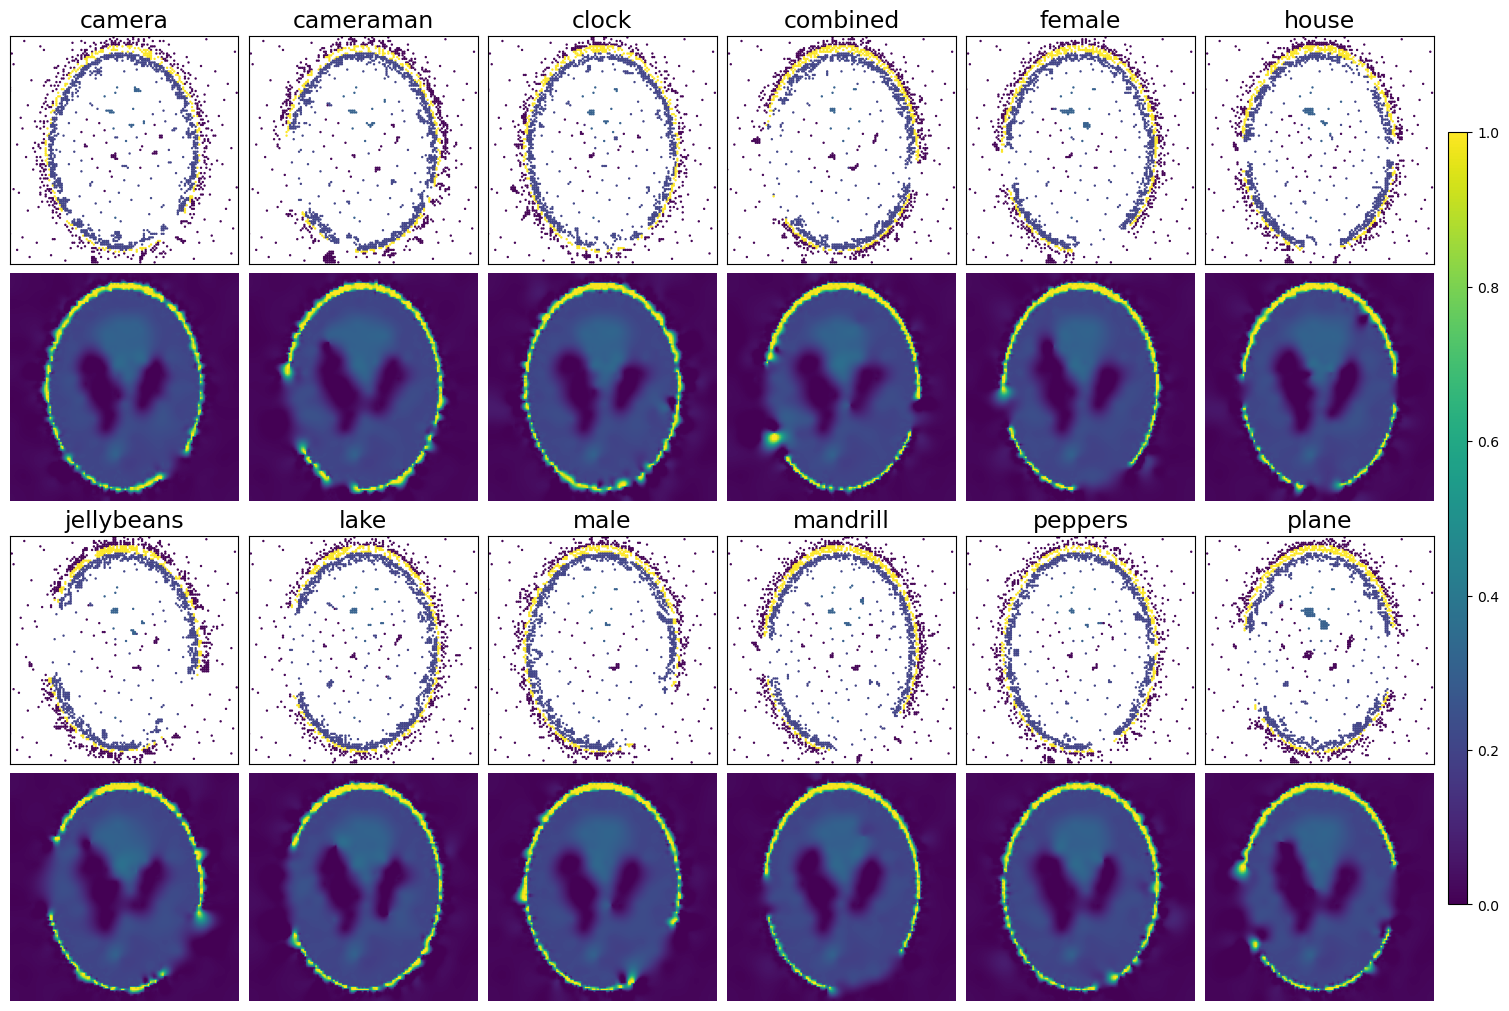

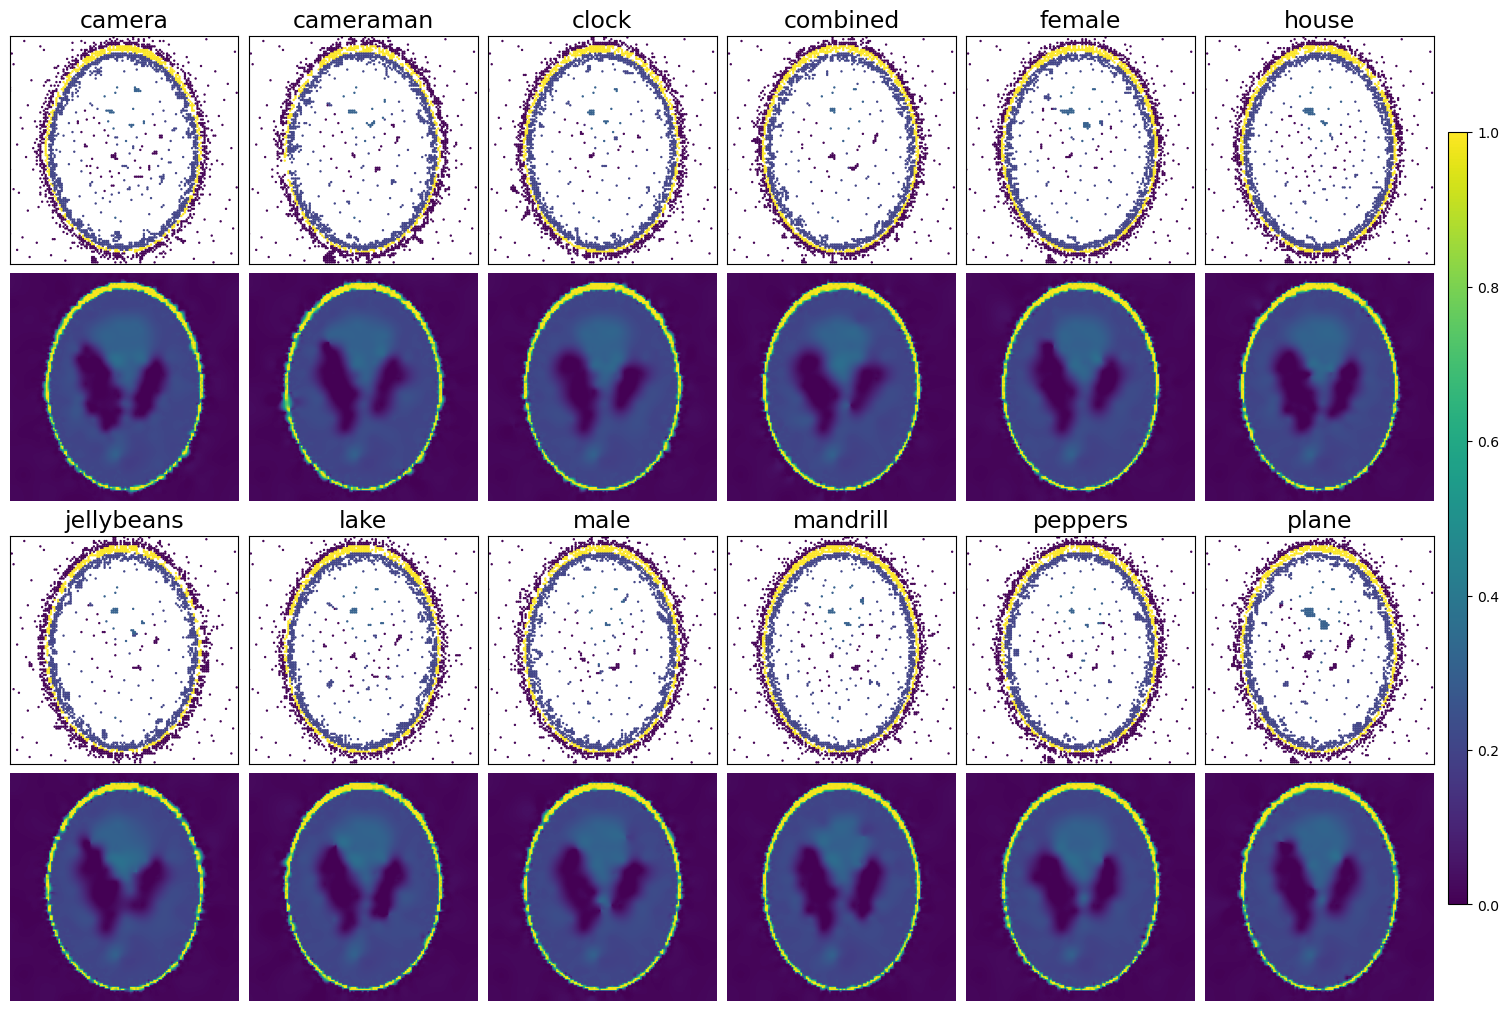

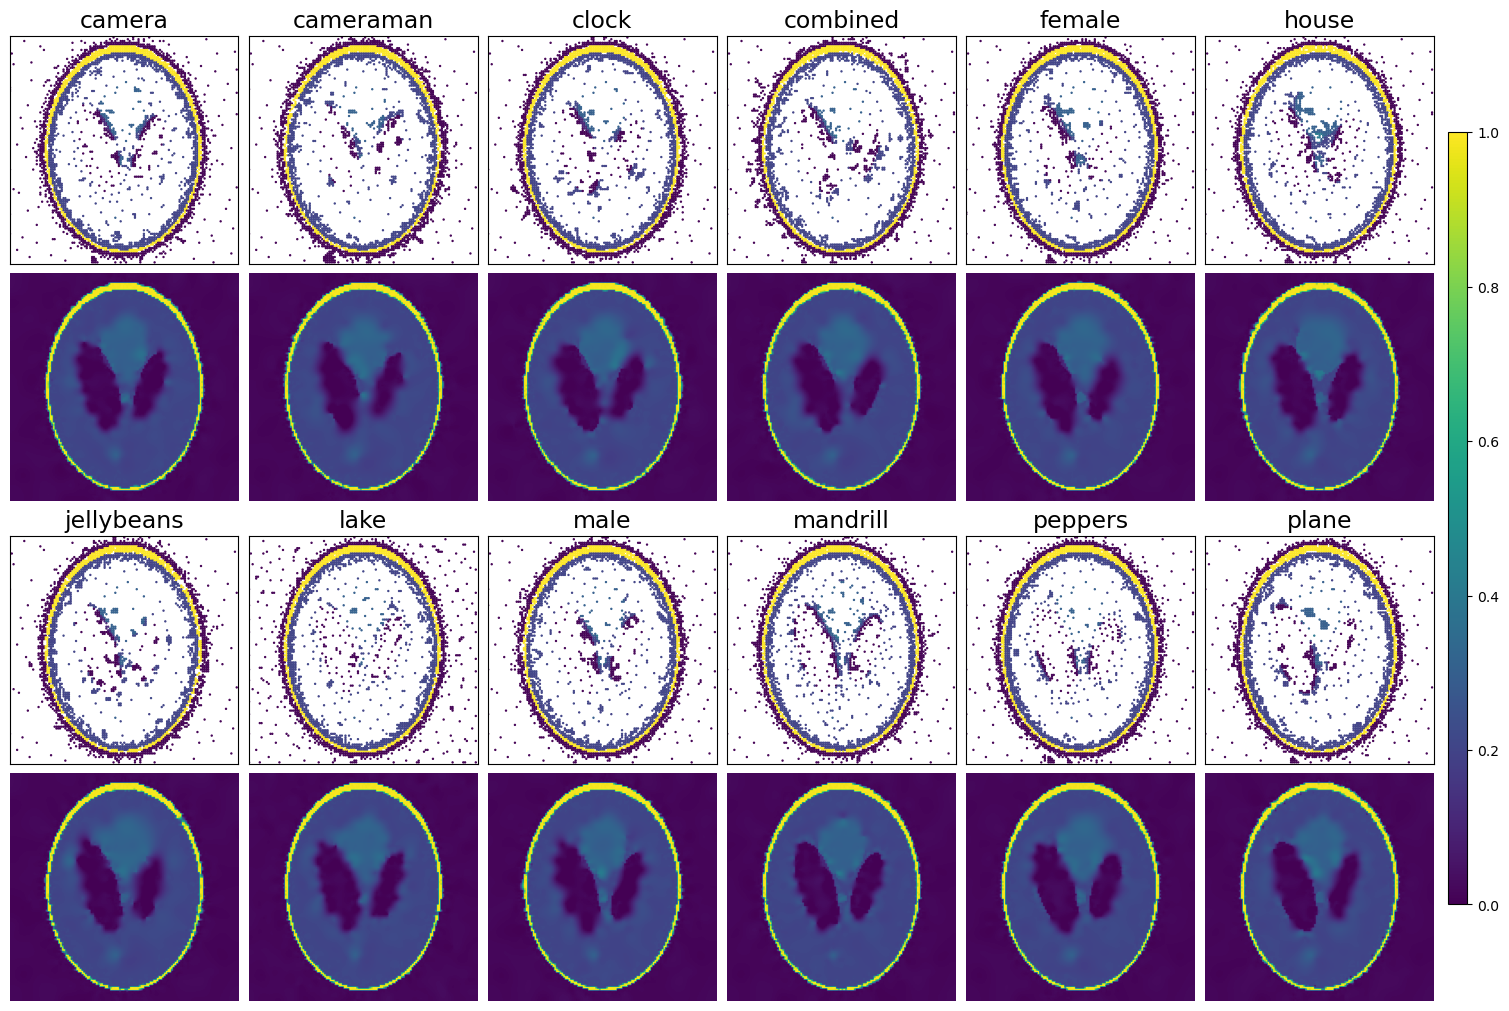

In [91]:
for n, r in enumerate(ratios_to_plot):
    fig, axs = plt.subplots(4, 6, figsize=[15, 10], constrained_layout=True)
    axs = axs.flatten()
    r_perc = r * 100

    cmap = mpl.colormaps.get_cmap("viridis").copy()
    norm = plt.Normalize(0, 1)

    for iy, label in enumerate(results_all):
        ix = idxs_to_plot[label][n]
        mask = results_all[label]["masks"][ix]
        recons = results_all[label]["recons_bh"][ix]
        # axs[iy * 2].imshow(masks[label][ix])
        #
        # axs[iy * 2].axis('off')
        ypoints, xpoints = np.where(mask)

        rmax = slp[ypoints, xpoints].max()
        rmin = slp[ypoints, xpoints].min()

        recons_renorm = renormalize(recons, min_value=rmin, max_value=rmax) / 100
        ints = recons_renorm[ypoints, xpoints]

        _ic = (iy // 6) * 6 * 2 + iy % 6
        cax = axs[_ic].scatter(xpoints, ypoints, c=ints, norm=norm, cmap=cmap, s=0.5, rasterized=False, zorder=0)
        cax.set_edgecolors = None
        axs[_ic].set_aspect("equal")
        # plt.text(6, 20, f'{percent}%', fontsize=25, c='red')
        # plt.title(f'{label} ({percent}%)', fontsize=16)
        axs[_ic].set_xticks([])
        axs[_ic].set_yticks([])
        axs[_ic].set_xlim(0, 128)
        axs[_ic].set_ylim(0, 128)
        axs[_ic].set_title(label, fontsize=17)
        axs[_ic].invert_yaxis()
        # for im in axs[iy * 2].get_images():
        #    im.clim(0, slp.max())

        axs[_ic + 6].imshow(recons_renorm, rasterized=False)
        axs[_ic + 6].axis("off")

    fig.colorbar(cax, ax=axs, shrink=0.8, pad=0.01, aspect=40)

    # fig.suptitle(f"{r_perc:3.0f}%")
    # plt.savefig(f"{figures_dir}/comparisons_{r_perc:3.0f}.svg", bbox_inches="tight", dpi=400, transparent=True)
    plt.savefig(f"{figures_dir}/comparisons_{r_perc:2.0f}.pdf", bbox_inches="tight", dpi=300, transparent=True)
    plt.show()

In [90]:
! du -hc paper_figures_and_results/slp/*

248K	paper_figures_and_results/slp/comparisons_ 10.pdf
1.3M	paper_figures_and_results/slp/comparisons_10.pdf
312K	paper_figures_and_results/slp/comparisons_ 15.pdf
1.6M	paper_figures_and_results/slp/comparisons_15.pdf
316K	paper_figures_and_results/slp/comparisons_ 20.pdf
1.7M	paper_figures_and_results/slp/comparisons_20.pdf
324K	paper_figures_and_results/slp/comparisons_ 25.pdf
140K	paper_figures_and_results/slp/comparisons_ 30.pdf
32K	paper_figures_and_results/slp/nrmses.pdf
40K	paper_figures_and_results/slp/shepp_logan.pdf
32K	paper_figures_and_results/slp/ssims.pdf
5.9M	total


In [101]:
! du -hc paper_figures_and_results/slp/*

308K	paper_figures_and_results/slp/comparisons_10.pdf
312K	paper_figures_and_results/slp/comparisons_15.pdf
316K	paper_figures_and_results/slp/comparisons_20.pdf
32K	paper_figures_and_results/slp/nrmses.pdf
40K	paper_figures_and_results/slp/shepp_logan.pdf
32K	paper_figures_and_results/slp/ssims.pdf
1.1M	total
Stopping engine(s): 1680053079


Stopping cluster <Cluster(cluster_id='1680053077-ikxb', profile='default', controller=<after>, engine_sets=['1680053079'])>


In [37]:
rc.shutdown(hub=True)

engine set stopped 1680053079: {'exit_code': 0, 'pid': 1351777, 'identifier': 'ipengine-1680053077-ikxb-1680053079-1351663'}
Controller stopped: {'exit_code': 0, 'pid': 1351685, 'identifier': 'ipcontroller-1680053077-ikxb-1351663'}
